In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import sys
sys.executable

'/home/ubuntu/anaconda3/envs/facegan/bin/python'

In [17]:
import os
import pathlib
import numpy as np
import matplotlib.pyplot as plt
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

import tensorflow as tf
print(tf.__version__)

from PIL import Image

%matplotlib inline

1.12.2


In [5]:
%cd ~/FaceGAN/stylegan-encoder
!ls

/home/ubuntu/FaceGAN/stylegan-encoder
LICENSE.txt			       latent_vectors
Learn_direction_in_latent_space.ipynb  masks
Play_with_latent_directions.ipynb      metrics
README.md			       mona_example.jpg
StyleGAN_Encoder_Tutorial.ipynb        old_24-6_exps
__pycache__			       old_exps
adaptive.py			       out.txt
align_images.py			       output.txt
aligned_images			       output_vectors.npy
all_aligned_images		       pretrained_example.py
cache				       raw_images
config.py			       requirements.txt
data				       robust_loss
dataset_tool.py			       run_metrics.py
dnnlib				       swa.py
encode_images.py		       teaser.png
encoder				       train.py
exps				       train_effnet.py
ffhq_dataset			       train_resnet.py
generate_figures.py		       training
generated_images		       videos
latent_representations


In [6]:
#@title `loading StyleGAN network into memory`

import dnnlib, pickle
import dnnlib.tflib as tflib
tflib.init_tf()

synthesis_kwargs = dict(output_transform=dict(func=tflib.convert_images_to_uint8, 
                                              nchw_to_nhwc=True),
                        minibatch_size=1)

model_dir = 'cache/'
model_path = [model_dir+f for f in os.listdir(model_dir) if 'stylegan-ffhq' in f][0]
print("Loading StyleGAN model from %s..." %model_path)

with dnnlib.util.open_url(model_path) as f:
    generator_network, discriminator_network, averaged_generator_network = pickle.load(f)

print("StyleGAN loaded & ready for sampling!")

Loading StyleGAN model from cache/60362027561e3cdd18da081cf8f58c2c_karras2019stylegan-ffhq-1024x1024.pkl...
StyleGAN loaded & ready for sampling!


In [7]:
#@title `images viz utils`

def generate_images(generator, latent_vector, z = True):
    batch_size = latent_vector.shape[0]
    
    if z: #Start from z: run the full generator network
        return generator.run(latent_vector.reshape((batch_size, 512)), 
                             None, 
                             randomize_noise=False, 
                             **synthesis_kwargs)
    else: #Start from w: skip the mapping network
        return generator.components.synthesis.run(latent_vector.reshape((batch_size, 18, 512)), 
                                                  randomize_noise=False, 
                                                  **synthesis_kwargs)

def plot_imgs(model, rows, columns):
  for i in range(rows):
    f, axarr = plt.subplots(1,columns, figsize = (20,8))
    for j in range(columns):
      img = generate_images(model, np.random.randn(1,512), z = True)[0]
      axarr[j].imshow(img)
      axarr[j].axis('off')
      axarr[j].set_title('Resolution: %s' %str(img.shape))
    plt.show()

In [8]:
!pwd

/home/ubuntu/FaceGAN/stylegan-encoder


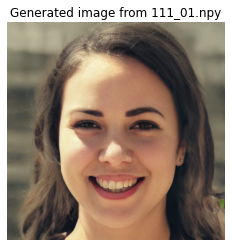

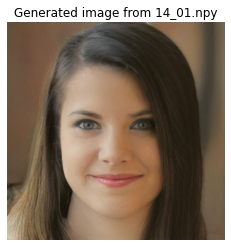

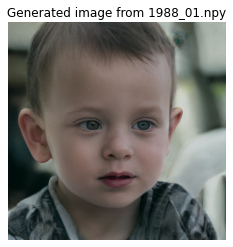

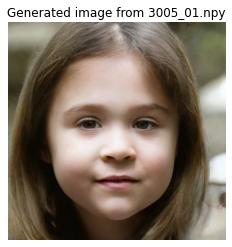

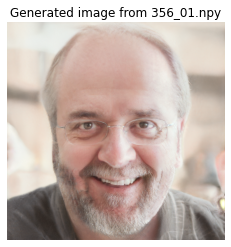

In [15]:
#@title `Results of Encoding`

EXP_PATH = '/home/ubuntu/FaceGAN/stylegan-encoder/exps-interface/exp4/latent_representations/'

for f in sorted(os.listdir(EXP_PATH)):
  w = np.load(EXP_PATH + f).reshape((1,18,-1))
  img = generate_images(averaged_generator_network, w, z = False)[0]
  plt.imshow(img)
  plt.axis('off')
  plt.title("Generated image from %s" %f)
  plt.show()

'/home/ubuntu/FaceGAN/stylegan-encoder/exps-interface/exp4'

In [25]:
#@title `Cherry pick images & dump latent vectors to disk`

good_images = [i for i in range(len(os.listdir(EXP_PATH)))] # encoded images numbers

latents = sorted(os.listdir(EXP_PATH))

os.makedirs(str(pathlib.Path(EXP_PATH).parent) + '/latent_vectors/', exist_ok=True)
out_file = str(pathlib.Path(EXP_PATH).parent) + '/latent_vectors/output_vectors.npy'

final_w_vectors = []
for img_id in good_images:
  w = np.load(EXP_PATH + latents[img_id])
  final_w_vectors.append(w)

final_w_vectors = np.array(final_w_vectors)
np.save(out_file, final_w_vectors)
print("%d latent vectors of shape %s \nsaved to %s!" %(len(good_images), str(w.shape), out_file))

5 latent vectors of shape (18, 512) 
saved to /home/ubuntu/FaceGAN/stylegan-encoder/exps-interface/exp4/latent_vectors/output_vectors.npy!


# Manipulating the faces

In [26]:
#@title `Cloning InterFaceGAN`
%cd ~/FaceGAN
# !git clone https://github.com/AmrMKayid/interfacegan
%cd /home/ubuntu/FaceGAN/interfacegan

/home/ubuntu/FaceGAN
/home/ubuntu/FaceGAN/interfacegan


In [27]:
out_file

'/home/ubuntu/FaceGAN/stylegan-encoder/exps-interface/exp4/latent_vectors/output_vectors.npy'

In [29]:
#@title `Load Our custom latent space vectors`

final_w_vectors = np.load(out_file)

print("%d latent vectors of shape %s loaded from %s!" %(final_w_vectors.shape[0], 
                                                        str(final_w_vectors.shape[1:]), 
                                                        'output_vectors.npy'))

5 latent vectors of shape (18, 512) loaded from output_vectors.npy!


In [30]:
#@title `Latent Space Configs`

latent_direction = 'age'      #@param ['age', 'eyeglasses', 'gender', 'pose', 'smile'] {allow-input: true}

# Controls how strongly we push the face into a certain latent direction (try 1-5)
morph_strength = 3           #@param {type:"slider", min:0, max:5, step:1} 

# The amount of intermediate steps/frames to render along the interpolation path
nr_interpolation_steps = 48  #@param {type:"slider", min:0, max:100, step:1} 

In [31]:
boundary_file = 'stylegan_ffhq_%s_w_boundary.npy' %latent_direction

print("Ready to start manipulating faces in the ** %s ** direction!" %latent_direction)
print("Interpolation from %d to %d with %d intermediate frames." %(-morph_strength, morph_strength, nr_interpolation_steps))
print("\nLoading latent directions from %s" %boundary_file)

Ready to start manipulating faces in the ** age ** direction!
Interpolation from -3 to 3 with 48 intermediate frames.

Loading latent directions from stylegan_ffhq_age_w_boundary.npy


In [32]:
#@title `Running latent interpolations`

import subprocess
return_code = subprocess.call("rm -r results/%s" %latent_direction, shell=True)

run_command = "python edit.py \
      -m stylegan_ffhq \
      -b boundaries/stylegan_ffhq_%s_w_boundary.npy \
      -s Wp \
      -i '/content/output_vectors.npy' \
      -o results/%s \
      --start_distance %.2f \
      --end_distance %.2f \
      --steps=%d" %(latent_direction, latent_direction, -morph_strength, morph_strength, nr_interpolation_steps)


print("Running latent interpolations... This should not take longer than ~1 minute")
print("Running: %s" %run_command)
return_code = subprocess.call(run_command, shell=True)

if not return_code:
  print("Latent interpolation successfully dumped to disk!")
else:
  print("Something went wrong, try re-executing this cell...")

Running latent interpolations... This should not take longer than ~1 minute
Running: python edit.py       -m stylegan_ffhq       -b boundaries/stylegan_ffhq_age_w_boundary.npy       -s Wp       -i '/content/output_vectors.npy'       -o results/age       --start_distance -3.00       --end_distance 3.00       --steps=48
Something went wrong, try re-executing this cell...


In [34]:
!rm -rf results

In [36]:
!python edit.py -m stylegan_ffhq \
               -b "{boundary_file}" \
               -s Wp \
               -i "{final_w_vectors}" \
               -o "results/{latent_direction}" \
               --start_distance "{-morph_strength}" \
               --end_distance "{morph_strength}" \
               --steps="{nr_interpolation_steps}"
               

[2020-06-28 13:53:16,307][INFO] Initializing generator.
[2020-06-28 13:53:16,584][WARNING] No pre-trained model will be loaded!
Traceback (most recent call last):
  File "edit.py", line 118, in <module>
    main()
  File "edit.py", line 72, in main
    model = StyleGANGenerator(args.model_name, logger)
  File "/home/ubuntu/FaceGAN/interfacegan/models/stylegan_generator.py", line 42, in __init__
    super().__init__(model_name, logger)
  File "/home/ubuntu/FaceGAN/interfacegan/models/base_generator.py", line 103, in __init__
    self.model.eval().to(self.run_device)
  File "/home/ubuntu/anaconda3/envs/facegan/lib/python3.6/site-packages/torch/nn/modules/module.py", line 443, in to
    return self._apply(convert)
  File "/home/ubuntu/anaconda3/envs/facegan/lib/python3.6/site-packages/torch/nn/modules/module.py", line 203, in _apply
    module._apply(fn)
  File "/home/ubuntu/anaconda3/envs/facegan/lib/python3.6/site-packages/torch/nn/modules/module.py", line 203, in _apply
    module._app